In [1]:
from IPython.display import display
import matplotlib.pyplot as plt

import json
import os
import pandas as pd
from collections import defaultdict


def compare_model_results(corpus, models, dates):
    with open(f'../data/{corpus}_test_lark.json') as f:
        test_data = json.load(f)

    test_data = [{
        'dialogue_id': d['id'],
        'utt_no': i,
        'speaker':speaker,
        'utt': utt,
        'da_tag': da_tag} for d in test_data 
            for i, (speaker, utt, da_tag) 
            in enumerate(zip(d['speakers'], d['utts'], d['da_tags'])) 
        ]

    df = pd.DataFrame(test_data)
    df = df.set_index(['dialogue_id', 'utt_no'])


    preds = defaultdict(lambda x: dict)
    for model, date in zip(models, dates):
        model_dir = f'../models/{corpus}-L_{model}_{date}/'
        files = os.listdir(model_dir)
        preds_file = [f for f in files if f.startswith('preds')][0]
        with open(os.path.join(model_dir, preds_file), 'r') as f:
            preds = json.load(f)
            preds = [((u['dialogue_id'], u['utt_no']), pred_da) 
                for pred_da, u in zip([da for d in preds for da in d], test_data)]
            preds = list(zip(*preds))
            preds = pd.Series(preds[1], index=preds[0])
            df[model] = preds
            
    return df


models = ['bert', 'bert_frozen', 'bert_random-init']
dates = ['2019-11-14', '2019-11-19', '2019-11-19']


dfs = compare_model_results('SWDA', models, dates)
display(dfs.head(10))

dfa = compare_model_results('AMI-DA', models, dates)
display(dfa.head(10))

speaker                                                utt  \
dialogue_id utt_no                                                              
sw2608      0            A                                             Okay .   
            1            B                          Do you want to go first ?   
            2            A                                 You can go first ,   
            3            A                                        or I will .   
            4            B                              Well , you go ahead .   
            5            A                                             Okay .   
            6            A  Well , I'm going to tell you what I'd have <la...   
            7            B                                       <laughter> .   
            8            A      Down in the south , we have a lot of shrimp ,   
            9            B                                           # Oh , #   

                             da_tag             bert      bert_frozen  \
dialogue_id utt_no                                                      
sw2608      0       fo_o_fw_"_by_bc  fo_o_fw_"_by_bc  fo_o_fw_"_by_bc   
            1                    qy               qy               qy   
            2              oo_co_cc               na               sd   
            3              oo_co_cc               sd                b   
            4                    ad               ad               sd   
            5                    aa                b                b   
            6                    sd               sd               sd   
            7                     x                x                b   
            8                    sd               sd               sd   
            9                     b                b                b   

                   bert_random-init  
dialogue_id utt_no                   
sw2608      0       fo_o_fw_"_by_bc  
            1                    qy  
            2                    ng  
            3                   b^m  
            4                    ad  
            5                    fc  
            6                    fc  
            7                     x  
            8                    sd  
            9                     b

speaker                                         utt  \
dialogue_id utt_no                                                       
IS1001d     0            A                                      Okay .   
            1            A           Je croix que c'est dommage de le    
            2            A  it will be sad to destroy this prototype .   
            3            A             It really looks like a banana .   
            4            C                            It is a banana .   
            5            A                 It is a banana . <laughter>   
            6            C              It is the essence of bananas .   
            7            C       I would be confused with this thing .   
            8            A                                               
            9            C                                               

                       da_tag       bert bert_frozen bert_random-init  
dialogue_id utt_no                                                     
IS1001d     0       ami_da_16   ami_da_9    ami_da_9         ami_da_9  
            1        ami_da_3  ami_da_16    ami_da_4         ami_da_4  
            2       ami_da_16   ami_da_9    ami_da_4         ami_da_4  
            3        ami_da_4   ami_da_9    ami_da_4         ami_da_9  
            4       ami_da_14   ami_da_4    ami_da_4         ami_da_4  
            5       ami_da_12   ami_da_9    ami_da_9         ami_da_4  
            6       ami_da_14   ami_da_9    ami_da_4         ami_da_4  
            7       ami_da_15   ami_da_9    ami_da_4         ami_da_9  
            8        ami_da_3   ami_da_3    ami_da_3         ami_da_3  
            9        ami_da_3   ami_da_3    ami_da_3         ami_da_3

# Comparing performance

How much does pre-training vs. fine-tuning contribute to model accuracy? 

We compare the DAR performance of standard Devlid, et al. (2018) pre-trained BERT (`bert`) as an utterance encoder to the same encoder architecture with no pre-training (`bert_random-init`),
We also compare the fine-tuned model (`bert`) to BERT with pre-training, but no fine-tuning (`bert_frozen`).

* `bert` -- BERT with pre-training and fine-tuning
* `bert_frozen` -- BERT with pre-training but no fine-tuning
* `bert_random-init` -- BERT with no pre training but with "fine-tunining"

In [2]:
print('SWDA')
for model in models:
    print(f"{model:<16}: {(dfs[model] == dfs['da_tag']).mean()*100:.2f}")
print()
print('AMI-DA')
for model in models:
    print(f"{model:<16}: {(dfa[model] == dfa['da_tag']).mean()*100:.2f}")


SWDA
bert            : 76.63
bert_frozen     : 55.19
bert_random-init: 73.79

AMI-DA
bert            : 67.20
bert_frozen     : 48.18
bert_random-init: 64.52


# Further analysis

Pre-trained bert performs better than the randomly-initialized model by about 3 percentage points, suggesting that the information learning in pre-training is at least somewhat useful in DAR.
However, the difference in accuracy between the pre-trained model that was fine-tuned (`bert`) and the one that was not (`bert_frozen`) is much larger.
This suggests that the representations learned in BERT's pre-training fail to encode information important to dialogue act recoginition.
In the following analysis we consider two questions raised by these results:

1. How does BERT's standard pre-training help in DAR? I.e., how does `bert` improve over `bert_random-init`?
2. How are the representations learned in BERT's standard pre-traninig lacking for DAR? I.e, how does `bert` improve over `bert_frozen`.

To answer these questions, we consider diffences in performance between the models, segmented by dialogue act.

## Impact of pre-training

First, we consider the impact of pre-training. The pre-trained model gives a modest performance boost (%3) over the  model with no-fine tuning.
The following figure shows how each dialogue act contributes to the increase in the accuracy of the model.
Namely, we look at dialogue acts that `bert` gets right and `bert_random-init` gets wrong, and normalize for ground-truth dialogue act frequency.

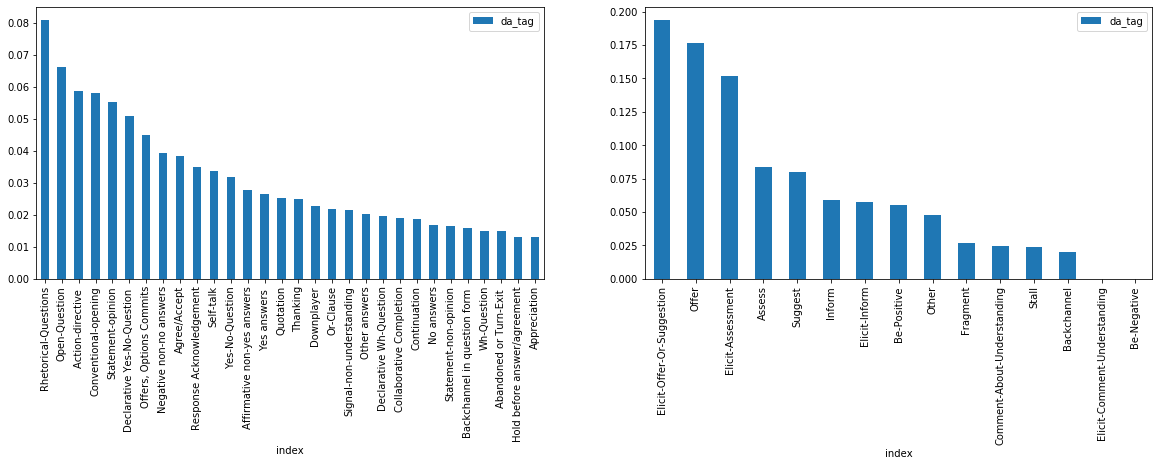

In [8]:
%matplotlib inline
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,5))

with open('SWDA_dialogue-acts.json') as f:
    swda_tags = json.load(f)
with open('AMI-DA_dialogue-acts') as f:
    ami_tags = json.load(f)
    
tag_freq_swda = dfs['da_tag'].value_counts() / len(dfs)
tag_freq_ami  = dfa['da_tag'].value_counts() / len(dfa)

bert_beats_random = dfs[(dfs['bert']!=dfs['bert_random-init']) & (dfs['bert']==dfs['da_tag'])].da_tag.value_counts()
normalized = (bert_beats_random / bert_beats_random.sum()) / tag_freq_swda
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(swda_tags.get)
normalized = normalized.set_index('index')
normalized.head(30).plot.bar(ax=axes[0])


bert_beats_random = dfa[(dfa['bert']!=dfa['bert_random-init']) & (dfa['bert']==dfa['da_tag'])].da_tag.value_counts()
normalized = (bert_beats_random / bert_beats_random.sum()) / tag_freq_ami
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(ami_tags.get)
normalized = normalized.set_index('index')
normalized.plot.bar(ax=axes[1])

Interestingly, much of the increase in accuracy attributable to fine-tuning in SWDA comes from corectly identifying various kinds of questions.

- SWDA: Top three are rhetorical question (`qh`), open questions (`qo`), and action-directive (`ad`). 
  - Note that action-directive often takes the form of a question ("Why don't you go first?")
- In AMI, the top three are elicit-offer-or-suggestion, offer, and elicit-assessment. 
  - Note that offer can take the form of a question too ("Would you like me to do that?")
- quesitons likely do appear BERT's standard pre-training corpus
- the next sentence selection task *may* encourage the model to learn representations that allow it to identify the different kinds of questions, given that their answer conditions (and therefore the form of sentences felicitously answering them) are different [are there answers following questions in books/wikipedia? rehetorical questions, maybe?]
- It *can not* be the case that the increase in accuracy comes from improved representations of question *answers*, since the DAR RNN model is purely right-to-left.
- TODO: Is it the case that the questions `bert_random-init` gets wrong are miss-classified as other kids of questions (this would be quite interesting!), or are the mis-classifications evenly distributed among other dialogue acts?

## Impact of fine-tuning

Next, we consider the impact of fine-tuning (or, conversely, the failures of pre-training).

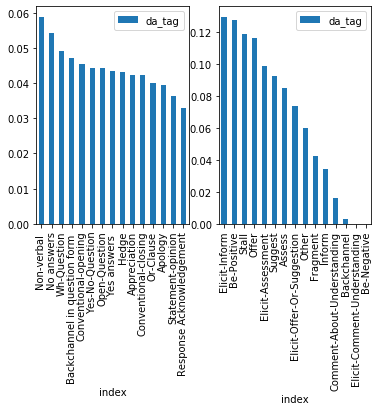

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 20))

ft_beats_frozen = dfs[(dfs['bert']!=dfs['bert_frozen']) & (dfs['bert']==dfs['da_tag'])]
ft_beats_frozen_counts = dfs[(dfs['bert']!=dfs['bert_frozen']) & (dfs['bert']==dfs['da_tag'])].da_tag.value_counts()
normalized = (ft_beats_frozen_counts / ft_beats_frozen_counts.sum()) / tag_freq_swda
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(swda_tags.get)
normalized = normalized.set_index('index')
normalized.head(15).plot.bar(ax=axes[0])


ft_beats_frozen = dfa[(dfa['bert']!=dfa['bert_frozen']) & (dfa['bert']==dfa['da_tag'])]
ft_beats_frozen_counts = dfa[(dfa['bert']!=dfa['bert_frozen']) & (dfa['bert']==dfa['da_tag'])].da_tag.value_counts()
normalized = (ft_beats_frozen_counts / ft_beats_frozen_counts.sum()) / tag_freq_ami
normalized = (normalized / normalized.sum()).sort_values(ascending=False)
normalized = pd.DataFrame(normalized).reset_index()
normalized['index'] = normalized['index'].apply(ami_tags.get)
normalized = normalized.set_index('index')
normalized.head(15).plot.bar(ax=axes[1])

I don't have as strong a story to tell about these results. 

- Non-verbal (SWDA) is near the top, which makes sense because non-verbal tokens are first seen by the model in fine-tuning.
- several question types (Wh-questions, yes-no-questions in SWDA; elicit-inform, elicit assessment) are also near the top here

### Fine-tuning and laughter

Here's another chance to see how laughter is used in DAR. 
Since the `<laughter>` token doesn't appear in the original vocabulary, only the fine-tuned models can meaningfully make use of laughter in utterance representations.
So, how much lafter appears in utterances that the fine-tuned model gets correct and the frozen model gets wrong?

In [6]:
ft_beats_frozen = dfs[(dfs['bert']!=dfs['bert_frozen']) & (dfs['bert']==dfs['da_tag'])]
laughter_ft = len(ft_beats_frozen[ft_beats_frozen.utt.apply(lambda x: '<laughter>' in x)]) / len(ft_beats_frozen)
laughter_base = len(dfs[dfs.utt.apply(lambda x: '<laughter>' in x)]) / len(dfs)

print('SWDA')
print(f"%{laughter_base*100:.2f} of utterances contain laughter overall")
print(f"%{laughter_ft*100:.2f} of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.")

print('AMI-DA')
ft_beats_frozen = dfa[(dfa['bert']!=dfa['bert_frozen']) & (dfa['bert']==dfa['da_tag'])]
laughter_ft = len(ft_beats_frozen[ft_beats_frozen.utt.apply(lambda x: '<laughter>' in x)]) / len(ft_beats_frozen)
laughter_base = len(dfa[dfa.utt.apply(lambda x: '<laughter>' in x)]) / len(dfa)

print(f"%{laughter_base*100:.2f} of utterances contain laughter overall")
print(f"%{laughter_ft*100:.2f} of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.")

SWDA
%4.57 of utterances contain laughter overall
%7.03 of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.
AMI-DA
%10.08 of utterances contain laughter overall
%9.21 of utterances misclassified by the frozen model, but correctly labeled by the fine-tuned model contian laughter.


- For SWDA, utterances containing laugthter have an outsized impact on the improvement granted by fine-tuning.
- For AMI, it's the opposite. Utterances contaniing laughter are no 
- Perhaps laughter is more helpful for DAR in SWDA than in AMI.
